## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf

## Basic parameters

In [2]:
RANDOM_STATE = 24 ## Set random state
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

TEST_SIZE = 0.2
EPOCHS = 100
BATCH_SIZE = 32

## 1.Loading data

In [3]:
df = pd.read_csv('FastagFraudDetection.csv')
df.head()

,Transaction_ID,Timestamp,Vehicle_Type,FastagID,TollBoothID,Lane_Type,Vehicle_Dimensions,Transaction_Amount,Amount_paid,Geographical_Location,Vehicle_Speed,Vehicle_Plate_Number,Fraud_indicator
0,1,1/6/2023 11:20,Bus,FTG-001-ABC-121,A-101,Express,Large,350,120,"13.059816123454882, 77.77068662374292",65,KA11AB1234,Fraud
1,2,1/7/2023 14:55,Car,FTG-002-XYZ-451,B-102,Regular,Small,120,100,"13.059816123454882, 77.77068662374292",78,KA66CD5678,Fraud
2,3,1/8/2023 18:25,Motorcycle,NaN,D-104,Regular,Small,0,0,"13.059816123454882, 77.77068662374292",53,KA88EF9012,Not Fraud
3,4,1/9/2023 2:05,Truck,FTG-044-LMN-322,C-103,Regular,Large,350,120,"13.059816123454882, 77.77068662374292",92,KA11GH3456,Fraud
4,5,1/10/2023 6:35,Van,FTG-505-DEF-652,B-102,Express,Medium,140,100,"13.059816123454882, 77.77068662374292",60,KA44IJ6789,Fraud


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Transaction_ID         5000 non-null   int64 
 1   Timestamp              5000 non-null   object
 2   Vehicle_Type           5000 non-null   object
 3   FastagID               4451 non-null   object
 4   TollBoothID            5000 non-null   object
 5   Lane_Type              5000 non-null   object
 6   Vehicle_Dimensions     5000 non-null   object
 7   Transaction_Amount     5000 non-null   int64 
 8   Amount_paid            5000 non-null   int64 
 9   Geographical_Location  5000 non-null   object
 10  Vehicle_Speed          5000 non-null   int64 
 11  Vehicle_Plate_Number   5000 non-null   object
 12  Fraud_indicator        5000 non-null   object
dtypes: int64(4), object(9)
memory usage: 507.9+ KB


In [5]:
df.describe()

,Transaction_ID,Transaction_Amount,Amount_paid,Vehicle_Speed
count,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,161.06200,141.261000,67.851200
std,1443.520003,112.44995,106.480996,16.597547
min,1.000000,0.00000,0.000000,10.000000
25%,1250.750000,100.00000,90.000000,54.000000
50%,2500.500000,130.00000,120.000000,67.000000
75%,3750.250000,290.00000,160.000000,82.000000
max,5000.000000,350.00000,350.000000,118.000000


In [6]:
# Convert Timestamp to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [7]:
print("Nan Values':", df['FastagID'].isnull().sum()) ## Checking for nan values

Nan Values': 549


In [8]:
df.dropna(subset=['FastagID'], inplace = True) ## Droping rows with missing fasttag id

## Visualization

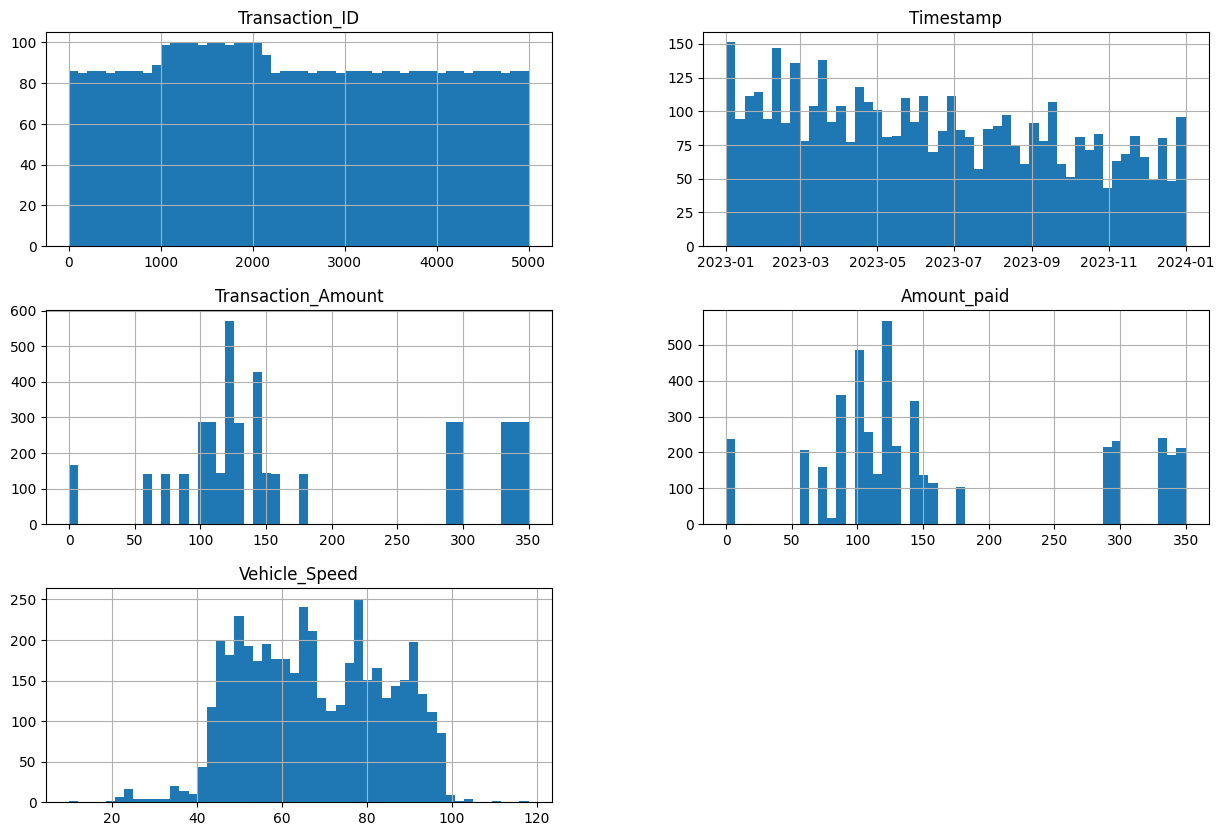

In [9]:
df.hist(figsize = (15,10), bins=50) ## Histogram
plt.show()

## Check imbalance

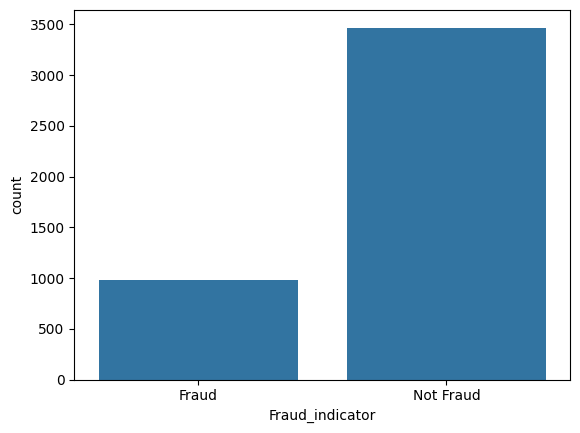

In [10]:
sns.countplot(x='Fraud_indicator', data=df) ## Countplot for labels
plt.show()

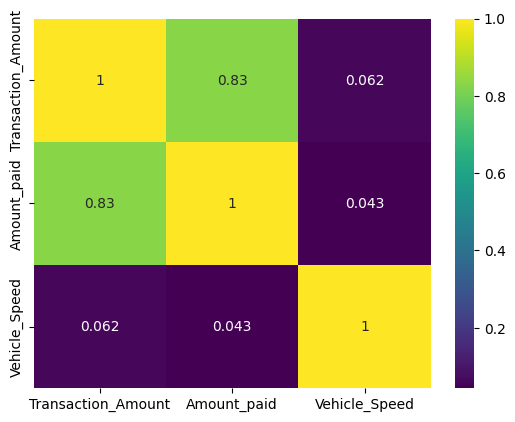

In [11]:
# Correlation matrix
correlation_matrix = df[['Transaction_Amount', 'Amount_paid', 'Vehicle_Speed']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis')
plt.show()

It is observed that vehicle speed is not significantly correlated to ammount paid and transaction ammount. Hence only transaction ammount and amount paid are considered for fraud detection

## Splitting data and normalizing

In [12]:
X  = df[['Transaction_Amount','Amount_paid']]  ## Feature selection
y= df['Fraud_indicator'] ## labels

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=TEST_SIZE,
                                                    random_state = RANDOM_STATE,
                                                    shuffle = True,
                                                    stratify= y) ## Creating train and test data

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3560, 2), (891, 2), (3560,), (891,))

In [13]:
## Normalizing the features
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

## Label encoding
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

## 2.Model Architecture

model layers = 3
neurons- [32,16,1]
activation function = Relu.
leraning_rate   0.001

In [14]:
#Neural network model

## Wights initialization
initializer = tf.keras.initializers.GlorotNormal(seed = RANDOM_STATE)

model = tf.keras.Sequential()

## Layer 1
model.add(tf.keras.layers.Dense(32,
                                activation='relu',
                                kernel_initializer=initializer,
                                bias_initializer = 'zero'))

## Layer 2
model.add(tf.keras.layers.Dense(16,
                                activation='relu',
                                kernel_initializer=initializer,
                                bias_initializer = 'zero'))

## Output layer
model.add(tf.keras.layers.Dense(1))

## Model training

In [15]:
## Loss function
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

## compiling model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [16]:
## Training model
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data = (X_test, y_test))

Epoch 1/100
112/112 [==============================] - 3s 9ms/step - loss: 0.5129 - accuracy: 0.6219 - val_loss: 0.3722 - val_accuracy: 0.8687
Epoch 2/100
112/112 [==============================] - 1s 5ms/step - loss: 0.2983 - accuracy: 0.9025 - val_loss: 0.2421 - val_accuracy: 0.9203
Epoch 3/100
112/112 [==============================] - 1s 6ms/step - loss: 0.1962 - accuracy: 0.9506 - val_loss: 0.1688 - val_accuracy: 0.9540
Epoch 4/100
112/112 [==============================] - 1s 6ms/step - loss: 0.1433 - accuracy: 0.9654 - val_loss: 0.1292 - val_accuracy: 0.9787
Epoch 5/100
112/112 [==============================] - 1s 6ms/step - loss: 0.1133 - accuracy: 0.9787 - val_loss: 0.1063 - val_accuracy: 0.9865
Epoch 6/100
112/112 [==============================] - 1s 6ms/step - loss: 0.0937 - accuracy: 0.9815 - val_loss: 0.0872 - val_accuracy: 0.9865
Epoch 7/100
112/112 [==============================] - 0s 4ms/step - loss: 0.0808 - accuracy: 0.9831 - val_loss: 0.0766 - val_accuracy: 0.9865

In [17]:
## saving training and testing accuracies and losses
hist = pd.DataFrame(history.history)
hist.head()

,loss,accuracy,val_loss,val_accuracy
0,0.512874,0.621910,0.372212,0.868687
1,0.298262,0.902528,0.242064,0.920314
2,0.196191,0.950562,0.168845,0.953984
3,0.143349,0.965449,0.129221,0.978676
4,0.113265,0.978652,0.106282,0.986532


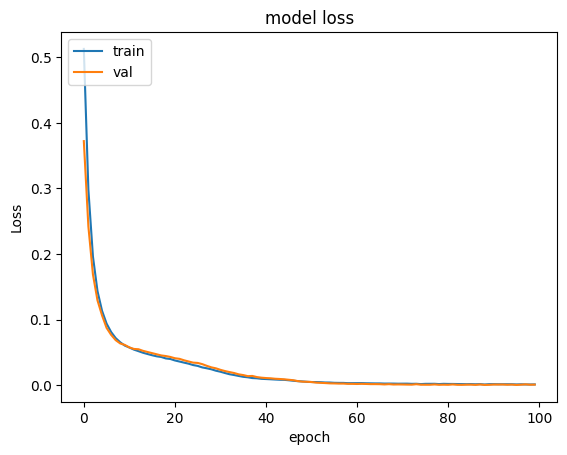

In [18]:
## Plotting training and testing loss
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model Evaluation

In [19]:
## Testing accuracy and loss after completion of training
eval = model.evaluate(X_test, y_test)
eval

28/28 [==============================] - 0s 2ms/step - loss: 6.6557e-04 - accuracy: 1.0000


[0.000665572879370302, 1.0]

In [20]:
## Prediction using trained model
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

## Getting accuracy , classification report and confusion matrix
print("Accuracy = ", accuracy_score(y_test, y_pred))
print("Classification report : ", classification_report(y_test, y_pred))
print("Confusion matrix : \n",confusion_matrix(y_test, y_pred))

28/28 [==============================] - 0s 2ms/step
Accuracy =  1.0
Classification report :                precision    recall  f1-score   support

           0       1.00      1.00      1.00       197
           1       1.00      1.00      1.00       694

    accuracy                           1.00       891
   macro avg       1.00      1.00      1.00       891
weighted avg       1.00      1.00      1.00       891

Confusion matrix : 
 [[197   0]
 [  0 694]]


In [21]:
## Saving preditions
pred = pd.DataFrame(y_pred)
pred.to_csv('predictions.csv')

## Experimentation Results
from results it is obereved that relu works better than tanh as accuracy is highr and loss is lower for same model hyperparameters.

0.001 learning rate is better as the loss curve is stable than 0.01 in majority of cases but 0.01 learning rate decreases the number of epochs and training time.

Increasing no of layers from 3 to 4 increases instability in training and testing loss.

No of neurons didnot significantly affect the results but 32\16\1 was observed to be better performing than 16\4\1

| Sr no | No of layers | No of neurons | Learning rate | activation function | Evaluation (Accuracy, loss)             | Comment                                                                                                                                      |
| ----- | ------------ | ------------- | ------------- | ------------------- | --------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------- |
| 1     | 3            | 32,16,1       | 0.001         | relu                | 0.000665572879370302, 1.0              |  test accuracy reaches 100% at 50 epoch. Loss curve was smooth                                                                               |
| 2     | 3            | 32,16,1       | 0.001         | tanh                | 0.005226566921919584, 1.0               |  test accuracy reaches 100% at 50 epoch. Loss curve was smooth                                                                               |
| 3     | 3            | 32,16,1       | 0.01          | relu                | 5.887750830879668e-06, 1.0              |  test accuracy reaches 100% at 10 epoch.  Very time saving. some peaks are observed indicating unstable loss                                                                                 |
| 4     | 3            | 32,16,1       | 0.01          | tanh                | 5.054456778452732e-06, 1.0              | Loss curve saw peaks indicating u=nstabilty around 20 epoch but was smooth afterwards and accuracy was 100% at 20 epoch                      |
| 5     | 3            | 16,4,1        | 0.001         | relu                | 0.00314393755979836, 1.0                | test accuracy reaches 100% at 65  epoch. Loss curve was fairly smooth. Memory efficient as no of parameters decreases.                       |
| 6     | 3            | 16,4,1        | 0.001         | tanh                | 0.0402032770216465, 0.9932659864425659  | test accuracy was less. There was significant difference between train and test loss. Loss stabilizes around 25 epoch. Regularization needed |
| 7     | 3            | 16,4,1        | 0.01          | relu                | 0.00024353814660571516, 1.0             |  test accuracy reaches 100% at 20 epoch. Some instability observed in loss curve.  Very time and memory efficient.                           |
| 8     | 3            | 16,4,1        | 0.01          | tanh                | 0.03887254372239113, 0.9932659864425659 | test accuracy was less. There was significant difference between train and test loss. Loss stabilizes around 30 epoch.                       |
| 9     | 4            | 32,16,4,1     | 0.001         | relu                | 0.0012902553426101804, 1.0              |  test accuracy reaches 100% at 40 epoch. Loss curve was smooth                                                                               |
| 10    | 4            | 32,16,4,1     | 0.001         | tanh                | 0.03947686031460762, 0.9932659864425659 | test accuracy is slightly less. Slight difference between training and test loss.                                                            |
| 11    | 4            | 32,16,4,1     | 0.01          | relu                | 0.40729767084121704, 0.8518518805503845 | sudden peaks are observed in loss and accuracy decreases significantly aoruund 85 epoch                                                      |
| 12    | 4            | 32,16,4,1     | 0.01          | tanh                | 0.03887353837490082, 0.9932659864425659 | test accuracy is slightly less. Significant difference between training and test loss. Regularization needed                                 |


#### Hence model 1 with model layers = 3 neurons- [32,16,1] , activation function = Relu, and  leraning_rate 0.001 is better model.